In [1]:
# Module import:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

In [2]:
# Data simulation:
x = np.arange(1, 100, 5) # Returns evenly spaced values within a given interval.
y = 2.5 + .5 * x + np.random.randn(20) * 10 # Random values in a given shape.
N = len(x)
x = np.reshape(x,[20,1])
K = 1

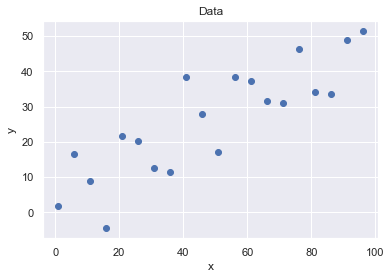

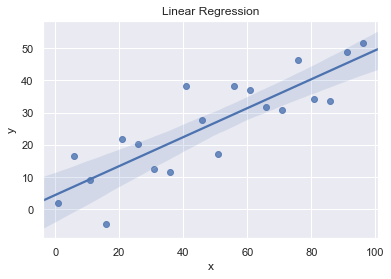

In [3]:
# Plot the data:
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
# plt.savefig('Data.png')
plt.show()
sns.regplot(x=x, y=y)
"""In the simplest invocation, both functions draw a scatterplot of two variables, x and y,
and then fit the regression model y ~ x and plot the resulting regression line and a 95% confidence
interval for that regression"""
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
# plt.savefig('Reg_Data.png')
plt.show()


In [4]:
# STAN model:
regress_code = """
data {
 int<lower = 0> N; // the number of observations
 int<lower = 0> K; // the number of columns in the covariate matrix X
 real y[N]; // the vector of response variables
 matrix[N,K] X; // the covariate matrix X
}
parameters {
 real a; // intercept
 vector[K] b; // remaining regression parameters
 real<lower=0> sigma; // standard deviation of the error term
}
transformed parameters {
 vector[N] mu; // fitted values
 mu = a + X*b;
}
model {
 a ~ cauchy(0,10); //prior for the intercept following Gelman 2008
 for(i in 1:K)
  b[i] ~ cauchy(0,2.5); //prior for the slopes following Gelman 2008
 y ~ normal(mu, sigma);
}
"""

In [5]:
# Dictionary containing all data to be passed to STAN:
regress_data_dict = {'X': x, 'y': y, 'N': N, 'K': K}

In [6]:
# Fit the model:
n_iter = 1000
n_chains = 4
model = pystan.StanModel(model_code=regress_code)
fit = model.sampling(data=regress_data_dict, iter=n_iter, chains=n_chains)
"""There are n_chains chains, and each chain as n_iter runs. First half of the n_iter runs 
for each chain are warmup, the second half produce the posterior draws."""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37a531631eb015176c7686f8727756e1 NOW.


'There are n_chains chains, and each chain as n_iter runs. First half of the n_iter runs \nfor each chain are warmup, the second half produce the posterior draws.'

In [7]:
# make a dataframe of parameter estimates for all chains
params = pd.DataFrame({'a': fit.extract()['a'], 'b': np.array([x[0] for x in fit.extract()['b']])})
medParam = params.median()

In [8]:
# Model summary:
print(fit)

Inference for Stan model: anon_model_37a531631eb015176c7686f8727756e1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        3.63    0.12    3.6  -3.55    1.3   3.63   6.03  10.75    869    1.0
b[1]     0.46  2.3e-3   0.07   0.34   0.42   0.46    0.5    0.6    836    1.0
sigma     9.0    0.05   1.61   6.49   7.87   8.81   9.84  12.79    874    1.0
mu[1]    4.09    0.12   3.54  -2.97   1.79   4.11   6.46  11.15    873    1.0
mu[2]    6.39    0.11   3.28  -0.17   4.25   6.44   8.58  12.95    897    1.0
mu[3]     8.7     0.1   3.03   2.77   6.73   8.74   10.7  14.78    931    1.0
mu[4]    11.0    0.09   2.79   5.49   9.19   11.0  12.88  16.57    979    1.0
mu[5]    13.3    0.08   2.57   8.26  11.64  13.31  15.04  18.47   1048    1.0
mu[6]    15.6    0.07   2.38  10.94  14.09   15.6  17.17  20.35   1148    1.0
mu[7]   17.91    0.06   2.22  13.

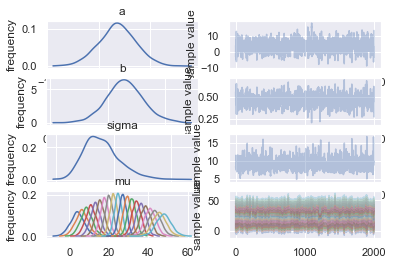

'This plot show the traces of the parameters on the left for all chains and you want all chains to\nconverge to similar values (ie no divergence in the values). On the right side of the plot are the\nposterior distributions of the parameters.'

In [9]:
# Show a traceplot of ALL parameters:
fit.traceplot()
# plt.savefig('Traceplot_all.png')
plt.show()
"""This plot show the traces of the parameters on the left for all chains and you want all chains to
converge to similar values (ie no divergence in the values). On the right side of the plot are the
posterior distributions of the parameters."""

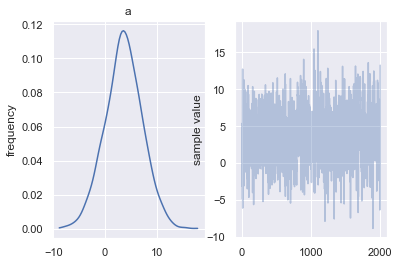

In [10]:
# Show a traceplot for single parameter:
fit.plot(['a'])
# plt.savefig('Traceplot_a.png')
plt.show()

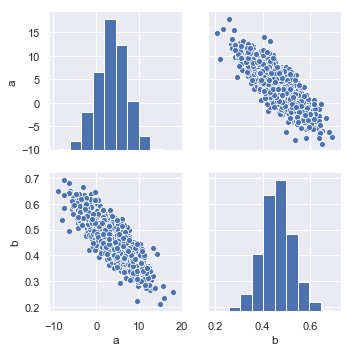

'A helpful summary plot is the pairwise correlation between the parameters, if each parameters\nis adding additional independent information, the points should form a shapeless cloud. If you have \nstrong correlation between several parameters, then you may consider dropping some as they do not add \nextra information.'

In [11]:
# Show a pairplot of the parameter:
sns.pairplot(params)
# plt.savefig('Pairplot.png')
plt.show()
"""A helpful summary plot is the pairwise correlation between the parameters, if each parameters
is adding additional independent information, the points should form a shapeless cloud. If you have 
strong correlation between several parameters, then you may consider dropping some as they do not add 
extra information."""

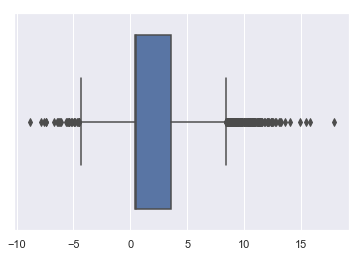

'Credible intervals are another summary for the different parameters in the models, the red bands \nin this graph show that the parameters have a probability of 0.8 to be within the bands. Which is an\neasier summary than the classical frequentist confidence intervals which tells us: “If I repeat my\nexperiment many times, the values of my parameters will be within this interval 80% of the time”.\n\nThe box shows the quartiles of the dataset while the whiskers extend to show the rest of the\ndistribution, except for points that are determined to be “outliers” using a method that is a\nfunction of the inter-quartile range.'

In [12]:
# Show a boxplot of the parameter:
sns.boxplot(params)
# plt.savefig('Boxplot.png')
plt.show()
"""Credible intervals are another summary for the different parameters in the models, the red bands 
in this graph show that the parameters have a probability of 0.8 to be within the bands. Which is an
easier summary than the classical frequentist confidence intervals which tells us: “If I repeat my
experiment many times, the values of my parameters will be within this interval 80% of the time”.

The box shows the quartiles of the dataset while the whiskers extend to show the rest of the
distribution, except for points that are determined to be “outliers” using a method that is a
function of the inter-quartile range."""

In [13]:
##### PREDICTION ####
# Make a prediction vector (the values of X for which you want to predict):
predX = np.arange(0, 100)
# Next, make a prediction function:
def stanPred(p):
	fitted = p[0] + p[1] * predX
	return pd.Series({'fitted': fitted})
# fitted values:
yhat = stanPred(medParam)
# Get the predicted values for all posterior draws. This is super convenient in pandas because
# it is possible to have a single column where each element is a list.
chainPreds = params.apply(stanPred, axis = 1) #this has n_iter*n_chains/2 rows and len(predX) columns


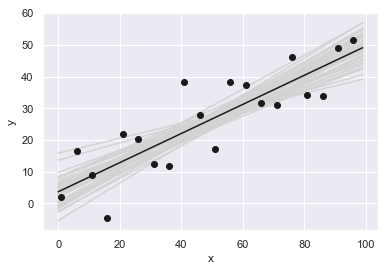

In [14]:
## PLOTTING
# create a random index for posterior draw sampling
idx = np.random.choice(int(n_iter*n_chains / 2.0)-1, 50)
# Plot the predicted values resulting from the sampled posterior draws.
# chainPreds.iloc[i, 0] gets predicted values from the ith sample
for i in range(len(idx)):
	plt.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
# original data
plt.plot(x, y, 'ko')
# fitted values
plt.plot(predX, yhat['fitted'], 'k')
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('Plot1.png')
plt.show()

In [15]:
# Make a function that iterates over every predicted values in every posterior draw sample and returns
# the quantiles:
def quantileGet(q):
    # make a list to store the quantiles
    quants = []
    # for every predicted value
    for i in range(len(predX)):
        # make a vector to store the predictions from each chain
        val = []
        # next go down the rows and store the values
        for j in range(chainPreds.shape[0]):
            val.append(chainPreds['fitted'][j][i])
        # return the quantile for the predictions.
        quants.append(np.percentile(val, q))
    return quants
 
# NOTE THAT NUMPY DOES PERCENTILES, SO MULTIPLE QUANTILE BY 100
# 2.5% quantile
lower = quantileGet(2.5)
#97.5
upper = quantileGet(97.5)

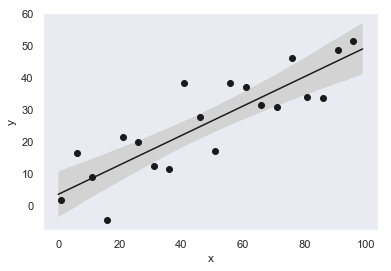

In [16]:
# plot this
fig = plt.figure()
ax = fig.add_subplot(111)
# shade the credible interval
ax.fill_between(predX, lower, upper, facecolor = 'lightgrey', edgecolor = 'none')
# plot the data
ax.plot(x, y, 'ko')
# plot the fitted line
ax.plot(predX, yhat['fitted'], 'k')
# supplementals
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
# plt.savefig('Plot2.png')
plt.show()